<a href="https://colab.research.google.com/github/ZombieCait/cnn_course/blob/master/lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Патракова Екатерина, РИМ-281226**

# Лабораторная работа №3. Бинарная сегментация избражений

В работе реализована тренировка сверточной нейронной сети Unet для сегментации левого желудочка на УЗИ изображениях сердца.

In [1]:
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Директория датасета состоит из двух директорий, в одной лежат изображения, в другой лежат разметка.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
! ls drive/'My Drive'/segmentation

person_segmentation  ultrasound


In [5]:
path = 'drive/My Drive/segmentation/ultrasound/'
os.listdir(path)

['labels', 'images']

Необходимо собрать все изображения и разметки из директорий

In [0]:
for folder in os.listdir(path):
    pathes = []
    for pth, dirs, files in os.walk(os.path.join(path, folder)):
        for file in files:
            pathes.append(os.path.join(pth, file))
    if folder == 'images':
        img_pathes = pathes
    elif folder == 'labels':
        lbl_pathes = pathes
        
img_pathes.sort()
lbl_pathes.sort()

Проверим, что названия в папке images и labels совпадают.

In [0]:
for img_pth, lbl_pth in zip(img_pathes, lbl_pathes):
    if os.path.join(*img_pth.split('/')[-3:]) != os.path.join(*lbl_pth.split('/')[-3:]):
        print('Каталоги не одинаковые')
        break

Реализуем класс Dataset

In [0]:
import torch
from torch.utils import data

T = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
])

class Dataset(data.Dataset):
    def __init__(self, path, subset = 'train', transform = None):

        for folder in os.listdir(path):
            pathes = []
            for pth, dirs, files in os.walk(os.path.join(path, folder)):
                for file in files:
                    pathes.append(os.path.join(pth, file))
            if folder == 'images':
                img_pathes = pathes
            elif folder == 'labels':
                lbl_pathes = pathes
   
        img_pathes.sort()
        lbl_pathes.sort()
        
        items = list(zip(img_pathes, lbl_pathes))
        
        if subset == 'train':
            self.items = items[: int(.7 * len(items))]
        elif subset == 'valid':
            self.items = items[int(.7 * len(items)): int(.9 * len(items))]
        elif subset == 'test':
            self.items = items[int(.9 * len(items)):]
            
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        img_name, msk_name = self.items[index]

        image = Image.open(img_name)
        mask = Image.open(msk_name).convert('L')

        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

Визаулизируем УЗИ-кадры и бинарные маски для кадров.

In [0]:
data = Dataset(path, subset='train', transform=None)

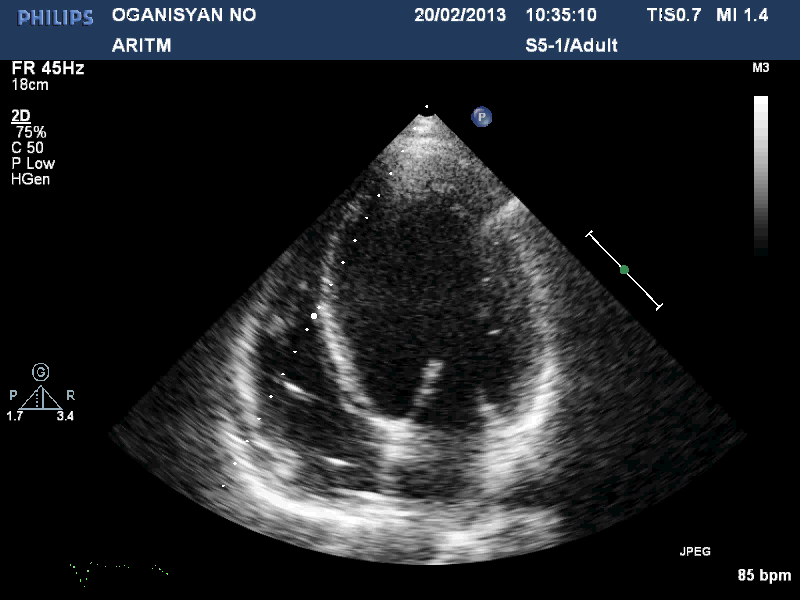

In [10]:
img, msk = data[0]
img

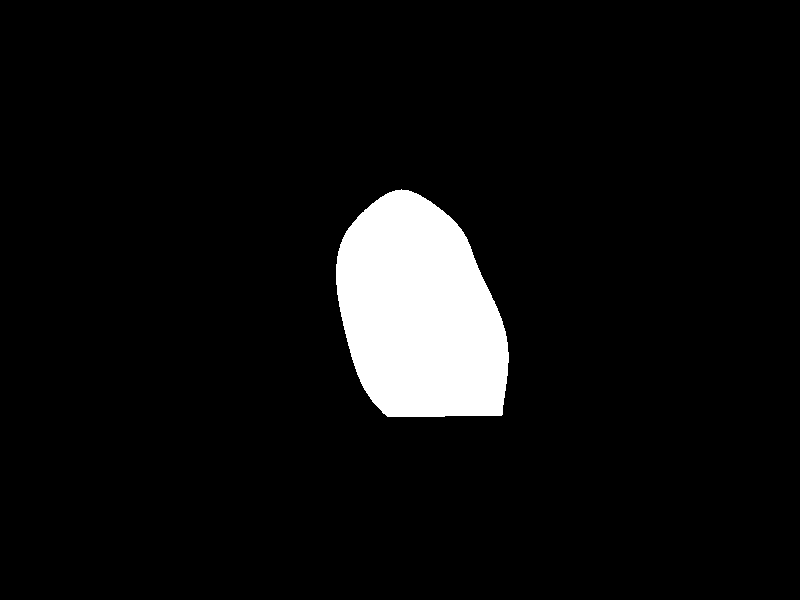

In [11]:
msk

In [0]:
train_data = Dataset(path, subset='train', transform=T)
valid_data = Dataset(path, subset='valid', transform=T)
test_data = Dataset(path, subset='test', transform=T)

In [0]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=16, 
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, 
                                           batch_size=16, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, 
                                           batch_size=1, 
                                           shuffle=False)

Используем модель Unet для сегментации снимков из библиотеки segmentation_models (https://github.com/qubvel/segmentation_models.pytorch).

In [14]:
! pip install segmentation-models-pytorch

     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.5.1-cp36-none-any.whl size=11768 sha256=9452cf348861833c748c731b29cb48201602ce70ba37e8edce07598d3a4c8def
  Stored in directory: /root/.cache/pip/wheels/52/0c/8e/58d91f29f0f8cbb45231a145312939a5423dc82c61cc731361
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=9a7872f6aa97268846578b4847898c4e795121ae25cc4b65f1a6545f0ec379d1
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


In [15]:
import segmentation_models_pytorch as smp

model = smp.Unet().to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 64.4MB/s]


Определяем функцию ошибки бинарную кроссэнтропию. Установи шаг обучения для энкодера и декодера сети, причем энкодер будет обучать медленнее.

In [0]:
from torch import nn 

loss = nn.BCEWithLogitsLoss()
loss.__name__ = 'bce_loss'
metrics = [
    smp.utils.metrics.IoU(eps=1.),
    smp.utils.metrics.Fscore(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-3},     

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

In [0]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)


In [18]:
max_score = 0

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
        
    if i == 5:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 3/3 [00:21<00:00,  7.27s/it, bce_loss - 2.706, iou_score - 0.05304, fscore - 0.1006]

Epoch: 1
valid: 100%|██████████| 3/3 [00:00<00:00,  7.18it/s, bce_loss - 0.5687, iou_score - 0.5775, fscore - 0.732]

Epoch: 2
valid: 100%|██████████| 3/3 [00:00<00:00,  6.94it/s, bce_loss - 0.4812, iou_score - 0.6083, fscore - 0.7544]

Epoch: 3
valid: 100%|██████████| 3/3 [00:00<00:00,  7.55it/s, bce_loss - 0.454, iou_score - 0.5616, fscore - 0.7157]

Epoch: 4
valid: 100%|██████████| 3/3 [00:00<00:00,  7.40it/s, bce_loss - 0.3784, iou_score - 0.6447, fscore - 0.7838]

Epoch: 5
valid: 100%|██████████| 3/3 [00:00<00:00,  7.38it/s, bce_loss - 0.3475, iou_score - 0.7255, fscore - 0.8407]
Decrease decoder learning rate to 1e-5!

Epoch: 6
valid: 100%|██████████| 3/3 [00:00<00:00,  7.81it/s, bce_loss - 0.3386, iou_score - 0.7246, fscore - 0.8402]

Epoch: 7
valid: 100%|██████████| 3/3 [00:00<00:00,  7.74it/s, bce_loss - 0.3374, iou_score - 0.7211, fscore - 0.8378]

Epoch: 8


In [19]:
valid_epoch.run(test_loader)

valid: 100%|██████████| 19/19 [00:11<00:00,  1.60it/s, bce_loss - 0.3317, iou_score - 0.7737, fscore - 0.8701]


{'bce_loss': 0.3317053302338249,
 'fscore': 0.8700889694063287,
 'iou_score': 0.7737311658106354}

Максимальное значение на валидации iou метрики - 77% и f-score - 87%. На тесте iou - 77%, f-score - 86%.

Возьмем другую функцию ошибки Dice и построим модель сегментации.

In [0]:
model = smp.Unet().to(device)

loss = smp.utils.losses.DiceLoss(eps=1.)

metrics = [
    smp.utils.metrics.IoU(eps=1.),
    smp.utils.metrics.Fscore(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-3},     

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [22]:
max_score = 0

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
        
    if i == 5:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 3/3 [00:00<00:00,  7.58it/s, dice_loss - 0.8201, iou_score - 6.381e-05, fscore - 6.381e-05]

Epoch: 1
valid: 100%|██████████| 3/3 [00:00<00:00,  7.82it/s, dice_loss - 1.231, iou_score - 0.0005571, fscore - 0.001107]

Epoch: 2
valid: 100%|██████████| 3/3 [00:00<00:00,  7.43it/s, dice_loss - 0.889, iou_score - 0.05588, fscore - 0.1057]

Epoch: 3
valid: 100%|██████████| 3/3 [00:00<00:00,  7.39it/s, dice_loss - 0.785, iou_score - 0.06789, fscore - 0.127]

Epoch: 4
valid: 100%|██████████| 3/3 [00:00<00:00,  7.59it/s, dice_loss - 0.6538, iou_score - 0.1032, fscore - 0.1867]

Epoch: 5
valid: 100%|██████████| 3/3 [00:00<00:00,  7.73it/s, dice_loss - 0.8589, iou_score - 0.08729, fscore - 0.1601]
Decrease decoder learning rate to 1e-5!

Epoch: 6
valid: 100%|██████████| 3/3 [00:00<00:00,  7.58it/s, dice_loss - 0.5928, iou_score - 0.08121, fscore - 0.1497]

Epoch: 7
valid: 100%|██████████| 3/3 [00:00<00:00,  7.58it/s, dice_loss - 0.7114, iou_score - 0.06429, fscor

In [23]:
valid_epoch.run(test_loader)

valid: 100%|██████████| 19/19 [00:00<00:00, 52.52it/s, dice_loss - 0.9726, iou_score - 0.03863, fscore - 0.07267]


{'dice_loss': 0.9726180089147467,
 'fscore': 0.07266509802177193,
 'iou_score': 0.03862687381019657}

Максимальное значение на валидации iou метрики - 79% и f-score - 88%. На тесте iou - 78%, f-score - 88%.

In [24]:
import torch.nn.functional as F

img, mask_true = test_data[0]
mask_pred = F.sigmoid(model(img.unsqueeze(0).to(device)))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


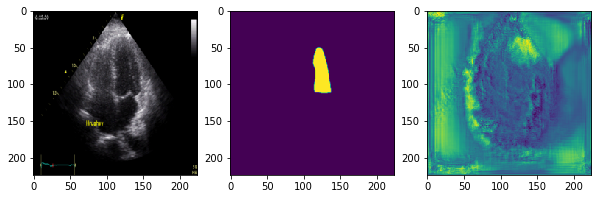

In [25]:
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(img.numpy().transpose(1,2,0))
plt.subplot(132)
plt.imshow(mask_true.squeeze().numpy())
plt.subplot(133)
plt.imshow(mask_pred.squeeze().cpu().detach().numpy())

## Задача

Натренировать Unet для сегментации людей на изображении. Использовать датасет 'person segmentation' по ссылке https://drive.google.com/open?id=1yi7Flk_Whidr2OZNdfmGkpgxbQPwIVtr.
Натрениройте несколько моделей Unet с различными энкодерами, проведите анализ качества полученных моделей. Сведите результаты в таблицу по всем моделям и для каждой подвиборке (train, valid, test). Приведите примеры кадров с людьми.

In [26]:
path = 'drive/My Drive/segmentation/person_segmentation/train'
os.listdir(path)

['masks', 'images']

In [0]:
for folder in os.listdir(path):
    pathes = []
    for pth, dirs, files in os.walk(os.path.join(path, folder)):
        for file in files:
            pathes.append(os.path.join(pth, file))
    if folder == 'images':
        img_pathes = pathes
    elif folder == 'masks':
        lbl_pathes = pathes
        
img_pathes.sort()
lbl_pathes.sort()

In [0]:
import torch
from torch.utils import data

T = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
])

class Dataset(data.Dataset):
    def __init__(self, path, subset = 'train', transform = None):

        for folder in os.listdir(path):
            pathes = []
            for pth, dirs, files in os.walk(os.path.join(path, folder)):
                for file in files:
                    pathes.append(os.path.join(pth, file))
            if folder == 'images':
                img_pathes = pathes
            elif folder == 'masks':
                lbl_pathes = pathes
   
        img_pathes.sort()
        lbl_pathes.sort()
        
        items = list(zip(img_pathes, lbl_pathes))
        
        if subset == 'train':
            self.items = items[: int(.7 * len(items))]
        elif subset == 'valid':
            self.items = items[int(.7 * len(items)): int(.9 * len(items))]
        elif subset == 'test':
            self.items = items[int(.9 * len(items)):]
            
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        img_name, msk_name = self.items[index]

        image = Image.open(img_name)
        mask = Image.open(msk_name).convert('L')

        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

In [0]:
data = Dataset(path, subset='train', transform=None)

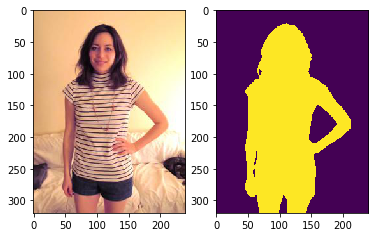

In [33]:
img, msk = data[134]
fig, axs = plt.subplots(1,2)
axs[0].imshow(img)
axs[1].imshow(msk)

In [0]:
train_data = Dataset(path, subset='train', transform=T)
valid_data = Dataset(path, subset='valid', transform=T)
test_data = Dataset(path, subset='test', transform=T)

In [0]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=16, 
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, 
                                           batch_size=16, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, 
                                           batch_size=1, 
                                           shuffle=False)

In [37]:
! pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-uii87gir
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-uii87gir
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33587 sha256=3858a6af383178343f8a2157f8639051754e336700ad0145d56d1868adfa1342
  Stored in directory: /tmp/pip-ephem-wheel-cache-9mvm9xg6/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [0]:
from torch import nn

In [0]:
results={}

N_EPOCHS=20

In [0]:
model_labels = ['resnet18', 'resnet50', 'inceptionresnetv2', 'dpn68', 'densenet201', 'vgg16','vgg19']

In [0]:
def train_bce_loss(model_name, device, loss_name='bce'):
  model = smp.Unet(model_name).to(device)

  if loss_name=='bce':  
    print("Функция ошибки бинарная кроссэнтропия")        
    loss = nn.BCEWithLogitsLoss()
    loss.__name__ = 'bce_loss'

  elif loss_name=='dice':
    print("Функция ошибки Dice")
    loss = smp.utils.losses.DiceLoss(eps=1.)

  metrics = [
      smp.utils.metrics.IoU(eps=1.),
      smp.utils.metrics.Fscore(eps=1.),
  ]

  optimizer = torch.optim.Adam([
      {'params': model.decoder.parameters(), 'lr': 1e-3},     
      {'params': model.encoder.parameters(), 'lr': 1e-5},  
  ])
          
  train_epoch = smp.utils.train.TrainEpoch(
      model, 
      loss=loss, 
      metrics=metrics, 
      optimizer=optimizer,
      device=device,
      verbose=True,
  )

  valid_epoch = smp.utils.train.ValidEpoch(
          model, 
          loss=loss, 
          metrics=metrics, 
          device=device,
          verbose=True,
      )
              
  max_score = 0  
  scores=[]

  for i in range(0, N_EPOCHS):
      print('\nEpoch: {}'.format(i + 1))
      train_logs = train_epoch.run(train_loader)
      with torch.no_grad():
          valid_logs = valid_epoch.run(valid_loader)
  
      scores.append({'train':train_logs,'valid':valid_logs})
  results[model_name]['scores'+'_'+loss_name]=scores

  with torch.no_grad():
      results[model_name]['test'+'_'+loss_name]=valid_epoch.run(test_loader)
        
  print('Визуализация данных')
          
  img, mask_true = test_data[116]
  mask_pred = F.sigmoid(model(img.unsqueeze(0).to(device)))
          
  plt.figure(figsize=(10,10))
  plt.subplot(131)
  plt.imshow(img.numpy().transpose(1,2,0))
  plt.subplot(132)
  plt.imshow(mask_true.squeeze().numpy())
  plt.subplot(133)
  plt.imshow(mask_pred.squeeze().cpu().detach().numpy())
  plt.show()

Encoder: resnet18
Функция ошибки бинарная кроссэнтропия

Epoch: 1
valid: 100%|██████████| 19/19 [00:02<00:00,  8.39it/s, bce_loss - 0.1926, iou_score - 0.9165, fscore - 0.9564]

Epoch: 2
valid: 100%|██████████| 19/19 [00:02<00:00,  8.53it/s, bce_loss - 0.1622, iou_score - 0.917, fscore - 0.9567]

Epoch: 3
valid: 100%|██████████| 19/19 [00:02<00:00,  8.49it/s, bce_loss - 0.1452, iou_score - 0.9267, fscore - 0.9619]

Epoch: 4
valid: 100%|██████████| 19/19 [00:02<00:00,  8.25it/s, bce_loss - 0.1366, iou_score - 0.9381, fscore - 0.968]

Epoch: 5
valid: 100%|██████████| 19/19 [00:02<00:00,  8.24it/s, bce_loss - 0.1272, iou_score - 0.9313, fscore - 0.9643]

Epoch: 6
valid: 100%|██████████| 19/19 [00:02<00:00,  8.49it/s, bce_loss - 0.1204, iou_score - 0.9345, fscore - 0.9661]

Epoch: 7
valid: 100%|██████████| 19/19 [00:02<00:00,  8.11it/s, bce_loss - 0.1172, iou_score - 0.9425, fscore - 0.9704]

Epoch: 8
valid: 100%|██████████| 19/19 [00:02<00:00,  8.56it/s, bce_loss - 0.1206, iou_score - 0.9

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


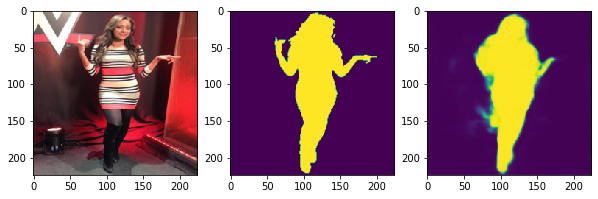

Функция ошибки Dice

Epoch: 1
valid: 100%|██████████| 19/19 [00:02<00:00,  8.69it/s, dice_loss - 0.8067, iou_score - 0.2188, fscore - 0.3583]

Epoch: 2
valid: 100%|██████████| 19/19 [00:02<00:00,  8.47it/s, dice_loss - -1.159, iou_score - 0.2816, fscore - 0.4372]

Epoch: 3
valid: 100%|██████████| 19/19 [00:02<00:00,  8.43it/s, dice_loss - -1.337, iou_score - 0.3024, fscore - 0.4622]

Epoch: 4
valid: 100%|██████████| 19/19 [00:02<00:00,  8.25it/s, dice_loss - 1.474, iou_score - 0.1519, fscore - 0.2612]

Epoch: 5
valid: 100%|██████████| 19/19 [00:02<00:00,  8.41it/s, dice_loss - 2.895, iou_score - 0.184, fscore - 0.3084]

Epoch: 6
valid: 100%|██████████| 19/19 [00:02<00:00,  8.21it/s, dice_loss - 1.408, iou_score - 0.207, fscore - 0.3413]

Epoch: 7
valid: 100%|██████████| 19/19 [00:02<00:00,  7.96it/s, dice_loss - -3.576, iou_score - 0.2646, fscore - 0.4169]

Epoch: 8
valid: 100%|██████████| 19/19 [00:02<00:00,  8.49it/s, dice_loss - 1.698, iou_score - 0.3062, fscore - 0.4672]

Epoch: 9


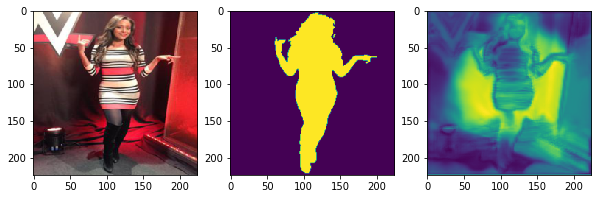

Encoder: resnet50
Функция ошибки бинарная кроссэнтропия

Epoch: 1
valid: 100%|██████████| 19/19 [00:02<00:00,  7.10it/s, bce_loss - 0.1783, iou_score - 0.896, fscore - 0.945]

Epoch: 2
valid: 100%|██████████| 19/19 [00:02<00:00,  7.13it/s, bce_loss - 0.1562, iou_score - 0.906, fscore - 0.9506]

Epoch: 3
valid: 100%|██████████| 19/19 [00:02<00:00,  7.16it/s, bce_loss - 0.1405, iou_score - 0.9204, fscore - 0.9585]

Epoch: 4
valid: 100%|██████████| 19/19 [00:02<00:00,  7.01it/s, bce_loss - 0.1227, iou_score - 0.9413, fscore - 0.9698]

Epoch: 5
valid: 100%|██████████| 19/19 [00:02<00:00,  7.54it/s, bce_loss - 0.1172, iou_score - 0.9462, fscore - 0.9723]

Epoch: 6
valid: 100%|██████████| 19/19 [00:02<00:00,  7.29it/s, bce_loss - 0.1099, iou_score - 0.9384, fscore - 0.9682]

Epoch: 7
valid: 100%|██████████| 19/19 [00:02<00:00,  7.74it/s, bce_loss - 0.105, iou_score - 0.9435, fscore - 0.9709]

Epoch: 8
valid: 100%|██████████| 19/19 [00:02<00:00,  7.22it/s, bce_loss - 0.09904, iou_score - 0.95

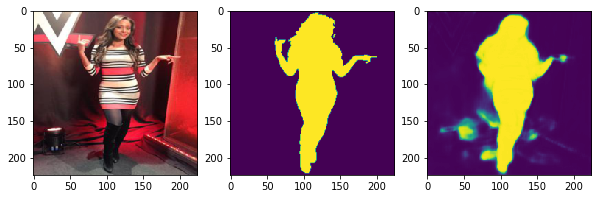

Функция ошибки Dice

Epoch: 1
valid: 100%|██████████| 19/19 [00:02<00:00,  7.69it/s, dice_loss - 0.8087, iou_score - 0.1682, fscore - 0.2873]

Epoch: 2
valid: 100%|██████████| 19/19 [00:02<00:00,  6.99it/s, dice_loss - 0.9161, iou_score - 0.1078, fscore - 0.1936]

Epoch: 3
valid: 100%|██████████| 19/19 [00:02<00:00,  7.68it/s, dice_loss - -0.06382, iou_score - 0.1177, fscore - 0.2097]

Epoch: 4
valid: 100%|██████████| 19/19 [00:02<00:00,  7.01it/s, dice_loss - -4.276, iou_score - 0.211, fscore - 0.3471]

Epoch: 5
valid: 100%|██████████| 19/19 [00:02<00:00,  7.54it/s, dice_loss - -0.5697, iou_score - 0.4223, fscore - 0.5928]

Epoch: 6
valid: 100%|██████████| 19/19 [00:02<00:00,  7.53it/s, dice_loss - 0.953, iou_score - 0.008359, fscore - 0.01656]

Epoch: 7
valid: 100%|██████████| 19/19 [00:02<00:00,  7.04it/s, dice_loss - 3.7, iou_score - 0.1645, fscore - 0.2813]

Epoch: 8
valid: 100%|██████████| 19/19 [00:02<00:00,  6.84it/s, dice_loss - 4.489, iou_score - 0.2117, fscore - 0.3482]

Epo

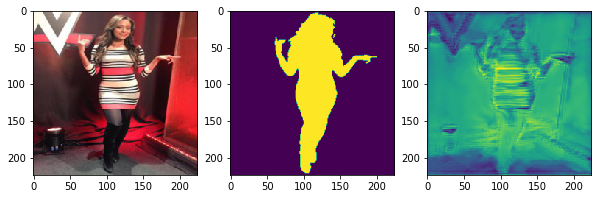

Encoder: inceptionresnetv2


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth" to /root/.cache/torch/checkpoints/inceptionresnetv2-520b38e4.pth
 69%|██████▉   | 148M/213M [07:15<03:17, 349kB/s]

In [0]:
for model_name in model_labels:
    print("Encoder: " + str(model_name))
    results[model_name]={}
    train_bce_loss(model_name, device, loss_name='bce')
    train_bce_loss(model_name, device, loss_name='dice')